<a href="https://colab.research.google.com/github/titika2013/Made_HPC/blob/main/HPC_HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install SALib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 758 kB 21.2 MB/s 
     |████████████████████████████████| 132 kB 51.9 MB/s 


In [24]:
import time
import numpy as np
from numba import jit, njit
from SALib.sample import saltelli, sobol
from SALib.test_functions import Ishigami
import matplotlib.pyplot as plt
import seaborn as sns


#Зафиксируйте какую-либо многомерную скалярную функцию
и реализуйте для неё анализ чувствительности по методу Соболя
на Python с использованием библиотеки SALib.

1. Проведите анализ чувствительности,
проверьте сходимость, измерьте тайминги, 25 баллов
2. Ускорьте вычисления Python с использованием любой 
из имеющихся возможностей (PyBind11, ctypes, cython, numba), 25 баллов
3. Попробуйте добавить параллелизм в вычисления, 25 баллов
4. Оформите и представьте результаты, 25 баллов

### 1. Baseline

In [4]:
#  Ishigami example
def eval_model(x):
    return (np.sin(x[0]) + 10 * np.power(np.sin(x[1]), 2) + 20 * np.power(x[2], 4) * np.sin(x[0]))


In [27]:
# baseline
time_baseline = []
n_baseline = []

problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-np.pi, np.pi]] * 3
}

time_00 = time.perf_counter()
for n in range(2 ** 10, 2 ** 15, 2 ** 10):  
    param_values = sobol.sample(problem, n, calc_second_order=True)
    zeros = np.zeros(param_values.shape[0])
    time_0 = time.perf_counter()
    for j in range(len(zeros)):
        zeros[j] = eval_model(param_values[j])
    time_1 = time.perf_counter()
    time_eval = time_1 - time_0    
    n_baseline.append(n)
    time_baseline.append(time_eval)
time_11 = time.perf_counter()


/usr/local/lib/python3.8/dist-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


In [28]:
print(f"time = {time_11 - time_00}")
print(f"mean time = {np.mean(time_baseline):0.3f} sec")

time = 51.513627352000185
mean time = 1.467 sec


### 2. Numba (jit)

In [31]:

#  Ishigami example
@njit
def eval_model_jit(x):
    return np.sin(x[0]) + 10 * np.power(np.sin(x[1]), 2) + 20 * np.power(x[2], 4) * np.sin(x[0])

In [29]:
time_jit = []
n_jit = []

In [32]:
time_00 = time.perf_counter()
for n in range(2 ** 10, 2 ** 15, 2 ** 10):  
    param_values = sobol.sample(problem, n, calc_second_order=True)
    zeros = np.zeros(param_values.shape[0])
    time_0 = time.perf_counter()
    for j in range(len(zeros)):
        zeros[j] = eval_model_jit(param_values[j])
    time_1 = time.perf_counter()
    time_eval = time_1 - time_0
    #print(f"eval time n = {n}: {time_eval:0.3f} sec")    
    n_jit.append(n)
    time_jit.append(time_eval)
time_11 = time.perf_counter()

/usr/local/lib/python3.8/dist-packages/scipy/stats/_qmc.py:1078: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  warnings.warn("The balance properties of Sobol' points require"


In [34]:
print(f"time (jit) = {time_11 - time_00}")
print(f"mean time (jit)= {np.mean(time_jit):0.3f} sec")

time (jit) = 9.935109514000033
mean time (jit)= 0.117 sec


In [35]:
print(f" acceleration with basic method:{np.mean(time_baseline)/np.mean(time_jit)}")

 acceleration with basic method:12.506799809574565


Numba gives 12 time acceleration!

###4. Results

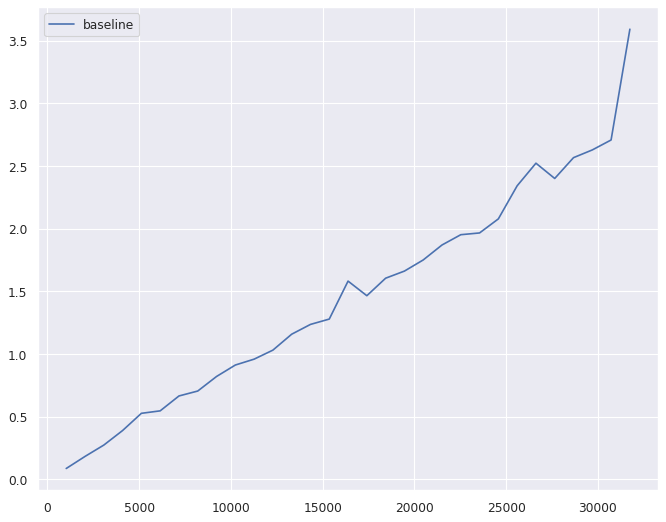

In [43]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set_theme(style="darkgrid")
sns.lineplot(x=n_baseline, y=time_baseline, label='baseline')

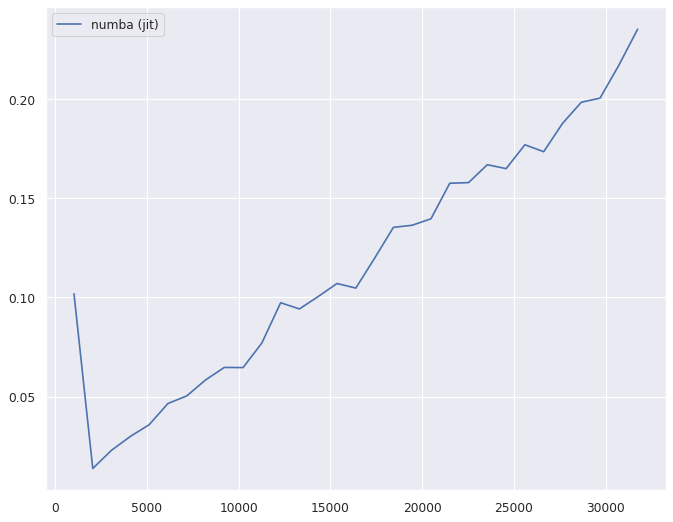

In [45]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set_theme(style="darkgrid") 
sns.lineplot(x=n_jit, y=time_jit, label='numba (jit)')

Самый первый пик произошел из-за времени работы компилятора (компилирование кода функции при первом вызове оптимизируемой функции).


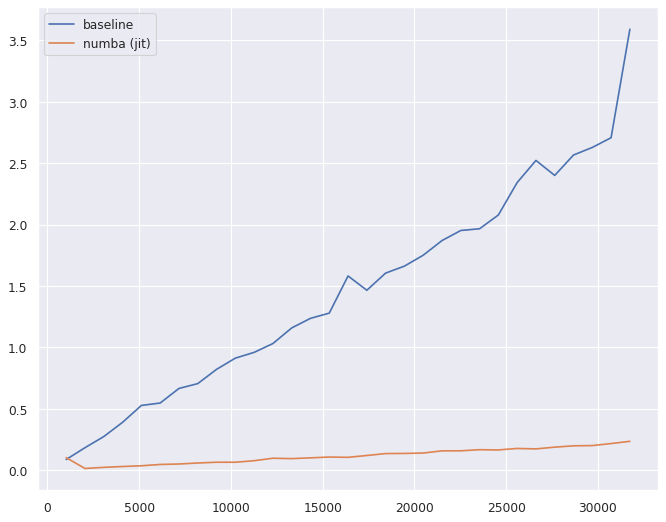

In [46]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set_theme(style="darkgrid")
sns.lineplot(x=n_baseline, y=time_baseline, label='baseline')
sns.lineplot(x=n_jit, y=time_jit, label='numba (jit)')

Видно, что jit компиляция сильно ускоряет время выполнения. 

In [47]:
print(f" acceleration with basic method:{np.mean(time_baseline)/np.mean(time_jit)}")

 acceleration with basic method:12.506799809574565


In [49]:
print(f'среднее время выполнения для базовой реализации {np.mean(time_baseline)} и для jit:{np.mean(time_jit)}')

среднее время выполнения для базовой реализации 1.4669224822902776 и для jit:0.11728999461295261
